# Charts for bus service opportunities by tract and CalEnviroScreen / Density Scores

* Density and CalEnviroScreen both grouped as low/med/high
* Provide some charts to accompany maps
* Heatmaps to show distribution?
* Scatterplot of pop density vs service density

In [1]:
# -- DO ONCE in terminal
# !conda install --yes -c conda-forge --file conda-requirements.txt

# npm worked a bit, but now has error using altair_saver
# https://stackoverflow.com/questions/62601904/altair-saver-valueerror-unsupported-format-png
#!npm install vega-lite vega-cli canvas

In [2]:
import altair as alt
import altair_saver
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import prep_data
import map_utils
import tract_utils

from IPython.display import display, SVG

alt.themes.enable("fivethirtyeight")
alt.data_transformers.enable('default', max_rows=10_000)
alt.renderers.enable('altair_saver', fmts=['vega-lite'])

pd.set_option("display.max_rows", 20)        

In [3]:
df = prep_data.generate_stop_times_tract_data()

# Address small numbers issue
df = df[df.Population > 10].reset_index(drop=True)

## Heatmap by Equity and Density Groups

In [4]:
sum_cols = ["stop_id", "itp_id", "Population", "num_jobs", "num_pop_jobs", "num_arrivals"]
mean_cols = []
count_cols = ["Tract"]
nunique_cols = []

t1 = tract_utils.aggregate_by_tract (df, 
                                     group_cols = ["popjobdensity_group", "equity_group"], 
                                     sum_cols = sum_cols, 
                                     mean_cols = mean_cols,
                                     count_cols = count_cols, 
                                     nunique_cols = nunique_cols
                                    ).astype("int")

LEGEND_LABELS = {
    1: "Low",
    2: "Med",
    3: "High"
}

LEGEND_ORDER = list(LEGEND_LABELS.values())

DENOM = 1_000
t1 = t1[t1.popjobdensity_group > 0].assign(
    arrivals_per_1k_pj = (t1.num_arrivals / t1.num_pop_jobs) * DENOM,
    stops_per_1k_pj = (t1.stop_id / t1.num_pop_jobs) * DENOM,
    #equity_group = t1.equity_group.map(LEGEND_LABELS),
    popjobdensity_group = t1.popjobdensity_group.map(LEGEND_LABELS),
)   


t1.head()

,popjobdensity_group,equity_group,Population,itp_id,num_arrivals,num_jobs,num_pop_jobs,stop_id,Tract,arrivals_per_1k_pj,stops_per_1k_pj
0,Low,1,6483574,1257,164076,1611989,8095563,8933,1369,20.267398,1.103444
1,High,1,1995393,516,259200,1274857,3270250,4706,418,79.259995,1.439034
2,High,2,4305526,1309,544942,3054002,7359528,11070,863,74.045781,1.504173
3,High,3,6459917,3058,948509,3020193,9480110,20574,1385,100.052531,2.170228
4,Low,3,2637676,434,81780,1308515,3946191,3895,461,20.723781,0.987028


In [5]:
t1.sort_values(["equity_group", "popjobdensity_group"])[
    ["popjobdensity_group", "equity_group", "Tract", "arrivals_per_1k_pj"]]

,popjobdensity_group,equity_group,Tract,arrivals_per_1k_pj
9,High,0,10,88.910675
10,Low,0,51,78.730720
11,Med,0,14,87.537549
1,High,1,418,79.259995
0,Low,1,1369,20.267398
6,Med,1,857,31.718332
2,High,2,863,74.045781
8,Low,2,776,19.654817
7,Med,2,1005,42.021289
3,High,3,1385,100.052531


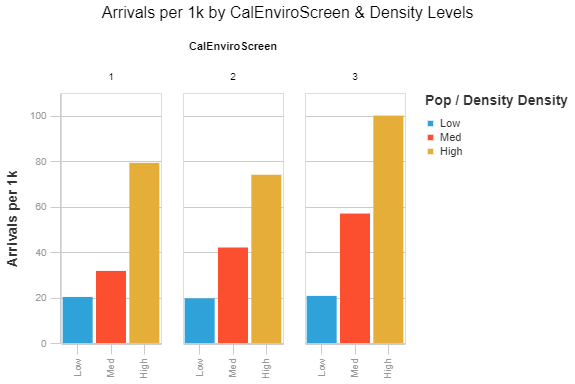

In [6]:
bar = (alt.Chart(t1[t1.equity_group > 0])
 .mark_bar()
 .encode(
     x=alt.X("popjobdensity_group:N", 
             axis=alt.Axis(title=""), 
             scale=alt.Scale(domain=LEGEND_ORDER)
            ),
     y=alt.Y("arrivals_per_1k_pj:Q",
             axis=alt.Axis(title="Arrivals per 1k")
            ),
     column=alt.Column("equity_group:N", title="CalEnviroScreen", 
                      ),
     color=alt.Color("popjobdensity_group:N", title="Pop / Density Density", 
                    scale=alt.Scale(domain=LEGEND_ORDER, 
                                    range=map_utils.FIVETHIRTYEIGHT_CATEGORY_COLORS
                                   )
                    )
 )
)


bar = (map_utils.preset_chart_config(bar)
       .properties(title="Arrivals per 1k by CalEnviroScreen & Density Levels", 
                  width = map_utils.chart_width*0.25)
)

display(bar)
bar.save("./img/arrivals_per_1k_bar.png")

In [7]:
def pivot_get_counts(df, index_col, group_col, value_col):
    df2 = df.pivot(index = index_col, 
                   columns = group_col, 
                   values = value_col)
    return df2

index_col = "popjobdensity_group"
group_col = "equity_group"


def make_heatmap(df, cmap, chart_title, xtitle, ytitle):
    chart = (sns.heatmap(df, cmap=cmap)
             .set(title=chart_title, xlabel=xtitle, ylabel=ytitle,
                 )
    )

    return chart

In [8]:
LOOP_DICT = {
    "Tract": "Tracts",
    "stop_id": "Bus Stops",
    "itp_id": "Operators",
    "arrivals_per_1k_pj": "Arrivals per 1k",
    "stops_per_1k_pj": "Stops per 1k",
} 

#plt.gcf().set_size_inches(1, 1)

for key, value in LOOP_DICT.items():
    subset_df = t1[t1.equity_group > 0]
    pivot_df = pivot_get_counts(subset_df, index_col, group_col, key)
    pivot_df = pivot_df.reindex(index=LEGEND_ORDER)
    
    print(key)
    display(pivot_df)
    #display(pivot_df.sort_index(axis=0, ascending=True))
    #display(pivot_df.reindex(index=LEGEND_ORDER))
    
    chart = make_heatmap(pivot_df, cmap="Blues", 
                 chart_title=(f"{value} by CalEnviroScreen" "\n and Density Levels"),
                 xtitle="CalEnviroScreen", ytitle="Pop / Job Density"   
                 )

    plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)
    plt.close()
    


Tract


equity_group,1,2,3
popjobdensity_group,,,
Low,1369,776,461
Med,857,1005,798
High,418,863,1385


/tmp/ipykernel_1294/401793160.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


stop_id


equity_group,1,2,3
popjobdensity_group,,,
Low,8933,5635,3895
Med,7196,10517,10774
High,4706,11070,20574


/tmp/ipykernel_1294/401793160.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


itp_id


equity_group,1,2,3
popjobdensity_group,,,
Low,1257,731,434
Med,909,1381,1200
High,516,1309,3058


/tmp/ipykernel_1294/401793160.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


arrivals_per_1k_pj


equity_group,1,2,3
popjobdensity_group,,,
Low,20.267398,19.654817,20.723781
Med,31.718332,42.021289,56.958989
High,79.259995,74.045781,100.052531


/tmp/ipykernel_1294/401793160.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


stops_per_1k_pj


equity_group,1,2,3
popjobdensity_group,,,
Low,1.103444,1.011442,0.987028
Med,1.304288,1.539419,1.885687
High,1.439034,1.504173,2.170228


/tmp/ipykernel_1294/401793160.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(f'./img/{key}.png', figsize=(4, 4), dpi=300)


## Scatterplot of pop density vs service density

In [9]:
y_col = "arrivals_per_1k_pj:Q"
group_col = "equity_group:N"
tooltip=['Tract', 'ZIP', 'County', 'City', 
         'pop_sq_mi', 'jobs_sq_mi', 'popjobs_sq_mi',
         'arrivals_per_1k_pj', 'equity_group']

def make_scatterplot(df, x_col, y_col, group_col, tooltip_list, chart_title):
    
    # Interactive chart should be centered near where 95th percentile data is
    # There are outliers...but let's not have it so zoomed out
    
    def colname_label(col):
        colname = col.split(":")[0]
        coltitle = colname.replace('_', ' ')
        return colname, coltitle
    
    x_colname, x_title = colname_label(x_col)
    y_colname, y_title = colname_label(y_col)
    
    MAX_X = df[x_colname].quantile(q=0.95)
    MAX_Y = df[y_colname].quantile(q=0.95)
    
    chart = (
        alt.Chart(df[((df[x_colname] > 0) & (df[y_colname] > 0))])
        .mark_point(size=30, fillOpacity=0.8)
        .encode(
            x=alt.X(x_col, 
                    scale=alt.Scale(domain=(0, MAX_X)), 
                    axis=alt.Axis(title=f"{x_title}")
                   ),
            y=alt.Y(y_col, 
                    scale=alt.Scale(domain=(0, MAX_Y)),
                    axis=alt.Axis(title=f"{y_title}")
                   ),
            color=group_col,
            tooltip=tooltip_list
        )
    )
    
    chart = (map_utils.preset_chart_config(chart)
             .properties(title=f"{chart_title}")
             .interactive()
            )
    
    return chart

In [10]:
x_col = "popjobs_sq_mi:Q"

# Scatterplot of pop & job density vs service density
c = make_scatterplot(df[(df.equity_group > 0)], 
                     x_col, y_col, group_col, tooltip, 
                     chart_title="Pop / Job Density vs Service Density")
c.save("./img/scatter_popjobdensity_servicedensity.html")

In [11]:
x_col = "pop_sq_mi:Q"

# Scatterplot of pop density vs service density
c = make_scatterplot(df[(df.equity_group > 0)], 
                     x_col, y_col, group_col, tooltip, 
                     chart_title="Pop Density vs Service Density")
c.save("./img/scatter_popdensity_servicedensity.html")

In [12]:
x_col = "jobs_sq_mi:Q"
# Scatterplot of pop density vs service density
c = make_scatterplot(df[(df.equity_group > 0)], 
                     x_col, y_col, group_col, tooltip, 
                     chart_title = "Job Density vs Service Density")
c.save("./img/scatter_jobdensity_servicedensity.html")